In [1]:
import os
import random
import time
import datetime
import numpy as np
import pandas as pd
import re

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight as cw
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
training_dir = '../input/train/'
testing_dir = '../input/test/'

train_files = os.listdir(training_dir)
test_files = os.listdir(testing_dir)

train_labels = []
for file in train_files:
    train_labels.append(file.split(".")[0])
    
df_train = pd.DataFrame({"id": train_files, "label": train_labels})
df_train.head()

,id,label
0,cat.11679.jpg,cat
1,dog.2811.jpg,dog
2,dog.2578.jpg,dog
3,dog.9238.jpg,dog
4,dog.7504.jpg,dog


In [3]:
df_test = pd.DataFrame({"id": test_files})
df_test["label"] = ["cat"]*(len(test_files))
df_test.head()

,id,label
0,3090.jpg,cat
1,8785.jpg,cat
2,10679.jpg,cat
3,7247.jpg,cat
4,8151.jpg,cat


In [4]:
#制作keras数据生成器
classes = ['cat', 'dog']

def get_data(batch_size=32, target_size=(96,96), class_mode="categorical", training_dir=training_dir,
             testing_dir=testing_dir, classes=classes, df_train=df_train, df_test=df_test):
    
    train_datagen = ImageDataGenerator(horizontal_flip=True, shear_range=0.2,zoom_range=0.2,
        rescale=1.0/255,validation_split=0.25)
    test_datagen = ImageDataGenerator(rescale=1.0/255)
    
    train_generator = train_datagen.flow_from_dataframe(df_train, training_dir, x_col='id', y_col='label', 
        has_ext=True, target_size=target_size, classes = classes, class_mode=class_mode, 
        batch_size=batch_size, shuffle=True, seed=42,subset='training')
    
    validation_generator = train_datagen.flow_from_dataframe(df_train, training_dir, x_col='id', y_col='label', 
        has_ext=True, target_size=target_size, classes = classes, class_mode=class_mode, 
        batch_size=batch_size, shuffle=True, seed=42, subset='validation')

    test_generator = test_datagen.flow_from_dataframe(df_test, testing_dir, x_col='id', y_col='label', 
        has_ext=True, target_size=target_size, classes = classes, class_mode=class_mode, 
        batch_size=batch_size, shuffle=False)
    
    class_weights = get_weight(train_generator.classes)
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps

def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [5]:
#画出模型的损失和预测的精度
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']
    ylim_pad = [0.01, 0.1]

    plt.figure(figsize=(15, 5))
    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    
    plt.subplot(121)
    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

    plt.subplot(122)
    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    
    plt.show()

In [6]:
#制作存储模型和日志的文件夹
model_dir = r"models/"
log_dir = r"logs/"

os.mkdir(model_dir)
os.mkdir(log_dir)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
model_dir, os.listdir(model_dir), log_dir, os.listdir(log_dir)

('models/', [], 'logs/', [])

In [7]:
#设置keras的回调函数
checkpoint = ModelCheckpoint(model_file, monitor='val_acc', save_best_only=True)
tensorboard = TensorBoard(log_dir=log_dir, update_freq='batch')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
callbacks = [reduce_lr, early_stopping, checkpoint]

In [8]:
#读取数据
batch_size = 32
target_size = (299, 299)
train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size, target_size=target_size, classes=classes, df_test=df_test)
#建立模型
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'] )
#开始训练
start_time = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weights)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print("\nElapsed Time: " + elapsed_time)

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.
Found 12500 images belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
586/586 [==============================] - 541s 924ms/step - loss: 0.1173 - acc: 0.9591 - val_loss: 0.0829 - val_acc: 0.9750
Epoch 2/30
586/586 [==============================] - 495s 845ms/step - loss: 0.0880 - acc: 0.9683 - val_loss: 0.0662 - val_acc: 0.9781
Epoch 3/30
586/586 [==============================] - 494s 843ms/step - loss: 0.0749 - acc: 0.9715 - val_loss: 0.0386 - val_acc: 0.9867
Epoch 4/30
586/586 [==============================] - 486s 830ms/step - loss: 0.0753 - acc: 0.9714 - val_loss: 0.0592 - val_acc: 0.9819

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/30
586/586 [==============================] - 485s 828

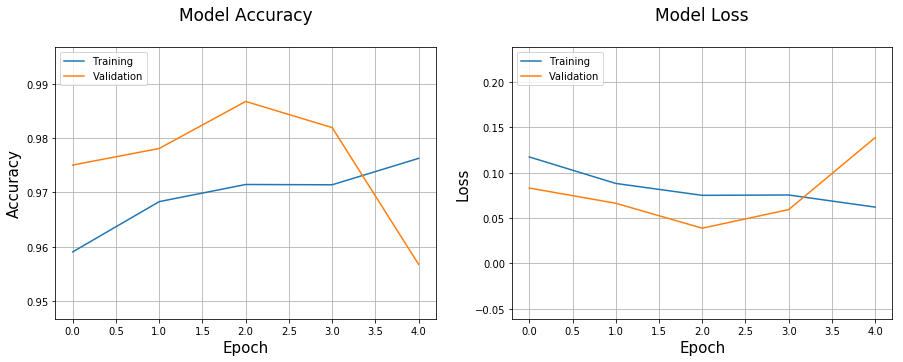

In [9]:
#画出模型的精度和损失
plot_performance(history=history)

In [10]:
def generate_result(model, test_generator, nsteps=len(test_generator)):
    y_preds = model.predict_generator(test_generator, steps=nsteps, verbose=1) 
    return y_preds, y_preds[:,1]

y_preds_all, y_preds = generate_result(model, test_generator)

391/391 [==============================] - 82s 210ms/step


In [11]:
df_test = pd.DataFrame({"id": test_generator.filenames, "label": y_preds})
df_test['id'] = df_test['id'].map(lambda x: x.split('.')[0])
df_test['id'] = df_test['id'].astype(int)
df_test = df_test.sort_values('id')
df_test.to_csv('submission.csv', index=False)
df_test.head()

,id,label
2322,1,9.970809e-01
5025,2,9.998186e-01
2481,3,9.992398e-01
5068,4,9.989728e-01
3495,5,1.780241e-07
